In [446]:
#requirements :
# 1- pip install geojson

In [489]:
# import libraries
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
import time
from utils import  get_ISRIC_results, extract_data, plot_geodataframe, assign_soil_category_numpy, assign_soil_category_pandas


### Questions 1& 2 & 3

#### Task : 
The task is to extract soil information for a specific area defined by a polygon from the ISRIC API. The area is divided into a grid of points, and the API is called for each point to extract certain properties. The results are then stored in a Pandas DataFrame.

#### Approach :

The code first loads a GeoJSON file, extracts the target polygon, and calculates its bounds. The next step is to create a grid of points within the polygon. This is done by iterating over a range of x and y values within the bounds of the polygon, and checking if each point is contained within the polygon using the contains method of the shapely.geometry.Polygon class. The grid points that are contained within the polygon are stored in a list.

The ISRIC API is then called for each grid point using the requests library, and the results are stored in a list. The code then extracts the values of each property for each grid point and stores them in a dictionary. Finally, the dictionary is used to create a Pandas DataFrame.
 

In [490]:
# Load GeoJSON file
gdf = gpd.read_file("test.geojson")
gdf

,geometry
0,"POLYGON ((5.33593 43.50158, 5.34942 43.48609, ..."


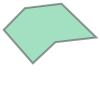

In [491]:
# Extract the target polygon
polygon = gdf.geometry[0]
polygon

In [492]:
# extract results for each point from the grid from the api 
results = get_ISRIC_results(polygon, grid_res=0.0025)

In [493]:
# get the main properties from results and build a dataframe
df = extract_data(results)
df.head()

,longitude,latitude,water_capacity,ph,oc_content,silt_content,sand_content,clay_content
0,5.338427,43.50109,10.0,7.2,2.2,36.0,35.0,27.0
1,5.338427,43.50359,10.0,7.4,1.9,39.0,33.0,27.0
2,5.340927,43.49609,10.0,7.3,1.9,37.0,33.0,29.0
3,5.340927,43.49859,10.0,7.3,2.0,37.0,34.0,28.0
4,5.340927,43.50109,10.0,7.2,2.1,36.0,33.0,29.0


In [494]:
# quick analysis on the data
df.describe()

,longitude,latitude,water_capacity,ph,oc_content,silt_content,sand_content,clay_content
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,5.354480,43.501695,10.326316,7.580000,1.682105,40.557895,30.768421,27.115789
std,0.009092,0.005728,0.471352,0.133369,0.150162,2.157204,2.013004,1.262075
min,5.338427,43.488590,10.000000,7.200000,1.300000,36.000000,25.000000,25.000000
25%,5.348427,43.498590,10.000000,7.500000,1.600000,39.000000,29.500000,26.000000
50%,5.353427,43.501090,10.000000,7.600000,1.700000,41.000000,31.000000,27.000000
75%,5.360927,43.506090,11.000000,7.700000,1.800000,42.000000,32.000000,28.000000
max,5.375927,43.511090,11.000000,7.800000,2.200000,44.000000,35.000000,30.000000



### Questions 4

#### Task : 
Create a map and overlay one of the above parameters on the map (eg ph map or carbon stock map)

#### Approach:
- The code first creates a GeoDataFrame from a pandas DataFrame by specifying the longitude and latitude columns as the x and y coordinates of the points.
- The GeoDataFrame is then plotted on a map using the plot method of the GeoDataFrame object.
- A column is selected to represent the soil parameter of interest and is passed to the column argument of the plot method. The colormap and legend are specified using the cmap and legend arguments, respectively.

#### Results :

Our analysis revealed that there is a negative correlation between pH and organic carbon content, and that the west region of the polygon generally has lower pH levels compared to the other regions. 

In [495]:
df['geometry'] = gpd.points_from_xy(df.longitude, df.latitude)
gdf_data = gpd.GeoDataFrame(df, geometry='geometry')

In [496]:
gdf_data.head()

,longitude,latitude,water_capacity,ph,oc_content,silt_content,sand_content,clay_content,geometry
0,5.338427,43.50109,10.0,7.2,2.2,36.0,35.0,27.0,POINT (5.33843 43.50109)
1,5.338427,43.50359,10.0,7.4,1.9,39.0,33.0,27.0,POINT (5.33843 43.50359)
2,5.340927,43.49609,10.0,7.3,1.9,37.0,33.0,29.0,POINT (5.34093 43.49609)
3,5.340927,43.49859,10.0,7.3,2.0,37.0,34.0,28.0,POINT (5.34093 43.49859)
4,5.340927,43.50109,10.0,7.2,2.1,36.0,33.0,29.0,POINT (5.34093 43.50109)


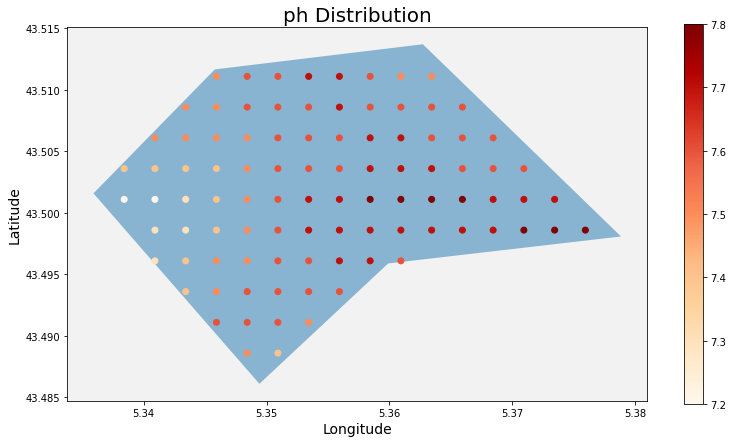

In [497]:
plot_geodataframe(gdf, gdf_data, 'ph', cmap='OrRd')

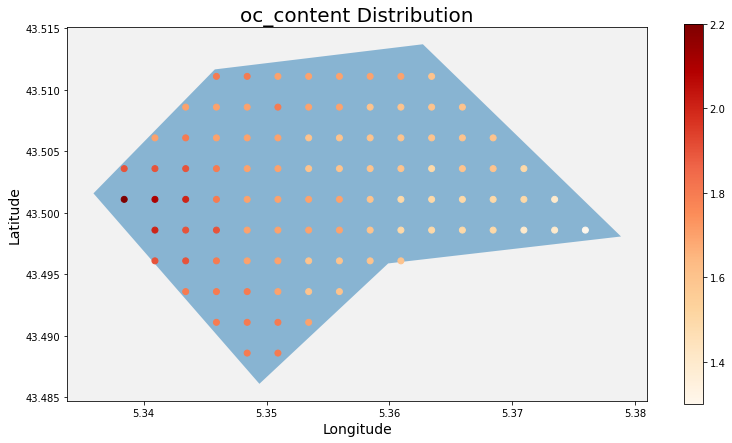

In [498]:
plot_geodataframe(gdf, gdf_data, 'oc_content', cmap='OrRd')

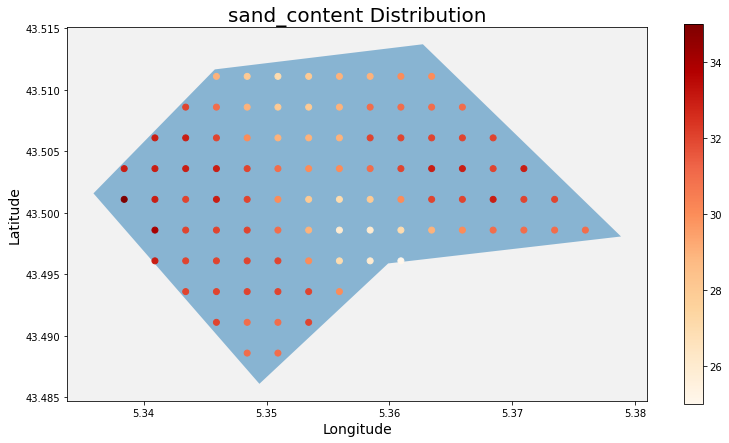

In [505]:
plot_geodataframe(gdf, gdf_data, 'sand_content', cmap='OrRd')

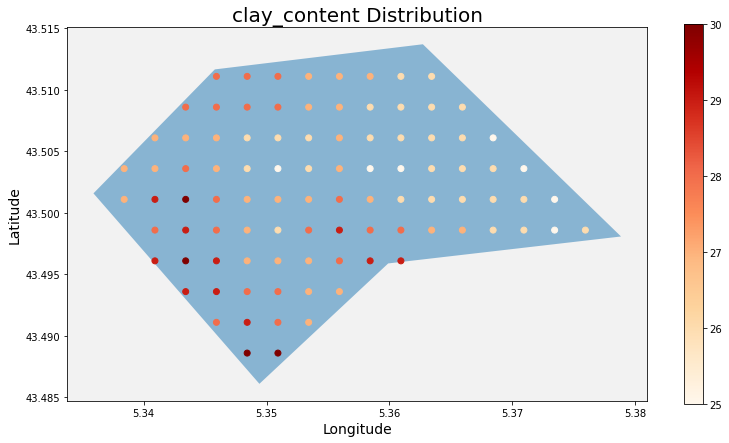

In [506]:
plot_geodataframe(gdf, gdf_data, 'clay_content', cmap='OrRd')

### Questions 5

#### Task : 
Add a column to the dataframe with the category of the soil. This can be derived using the texture triangle with the sand, clay and soil content as inputs
#### Approach :

- In the provided code, I defined a dictionary soil_categories which contains the soil categories and their corresponding sand, clay, and silt content ranges.

- The assign_soil_category_numpy() function uses NumPy broadcasting to compare the sand, clay, and silt content of a row with the content ranges in soil_categories_arr. It returns the soil category corresponding to the first True value in comparison_arr.

- The assign_soil_category_pandas() function uses a loop to compare the sand, clay, and silt content of a row with the content ranges in soil_categories. It returns the soil category if the row's sand, clay, and silt content are greater than or equal to the minimum values for a soil category.

- I then applied both assign_soil_category_numpy() and assign_soil_category_pandas() to create two new columns in the dataframe, soil_category_numpy and soil_category_pandas, respectively.

- To evaluate the performance of both functions, I recorded the execution time using the time module and printed it for both functions to compare their efficiency.

#### Results :
The numpy function is slightly faster

In [502]:
start_time = time.time()
# Apply the assign_soil_category_numpy function to create a new column with the soil category
df['soil_category_numpy'] = df.apply(assign_soil_category_numpy, axis=1)
print("Numpy function--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()
# Apply the assign_soil_category_pandas function to create a new column with the soil category
df['soil_category_pandas'] = df.apply(assign_soil_category_pandas, axis=1)
print("Pandas function--- %s seconds ---" % (time.time() - start_time))


Numpy function--- 0.006147146224975586 seconds ---
Pandas function--- 0.007959127426147461 seconds ---


In [503]:
df

,longitude,latitude,water_capacity,ph,oc_content,silt_content,sand_content,clay_content,geometry,soil_category_numpy,soil_category_pandas
0,5.338427,43.50109,10.0,7.2,2.2,36.0,35.0,27.0,POINT (5.33843 43.50109),Loam,Loam
1,5.338427,43.50359,10.0,7.4,1.9,39.0,33.0,27.0,POINT (5.33843 43.50359),Loam,Loam
2,5.340927,43.49609,10.0,7.3,1.9,37.0,33.0,29.0,POINT (5.34093 43.49609),Loam,Loam
3,5.340927,43.49859,10.0,7.3,2.0,37.0,34.0,28.0,POINT (5.34093 43.49859),Loam,Loam
4,5.340927,43.50109,10.0,7.2,2.1,36.0,33.0,29.0,POINT (5.34093 43.50109),Loam,Loam
...,...,...,...,...,...,...,...,...,...,...,...
90,5.370927,43.50109,11.0,7.7,1.5,41.0,32.0,26.0,POINT (5.37093 43.50109),Loam,Loam
91,5.370927,43.50359,11.0,7.6,1.5,41.0,33.0,25.0,POINT (5.37093 43.50359),Loam,Loam
92,5.373427,43.49859,11.0,7.8,1.4,42.0,31.0,25.0,POINT (5.37343 43.49859),Loam,Loam
93,5.373427,43.50109,11.0,7.7,1.4,41.0,32.0,25.0,POINT (5.37343 43.50109),Loam,Loam


### Questions 6

#### Task : 
The code generates a heatmap of soil pH values interpolated onto a regular grid of points.

#### Approach

The code defines the resolution of the regular grid and the boundaries of the area to be gridded. It then creates a regular grid of points using NumPy's meshgrid function, and interpolates the soil pH values onto the grid using SciPy's griddata function with linear interpolation. Finally, it plots the interpolated data as a heatmap using Matplotlib's imshow function.

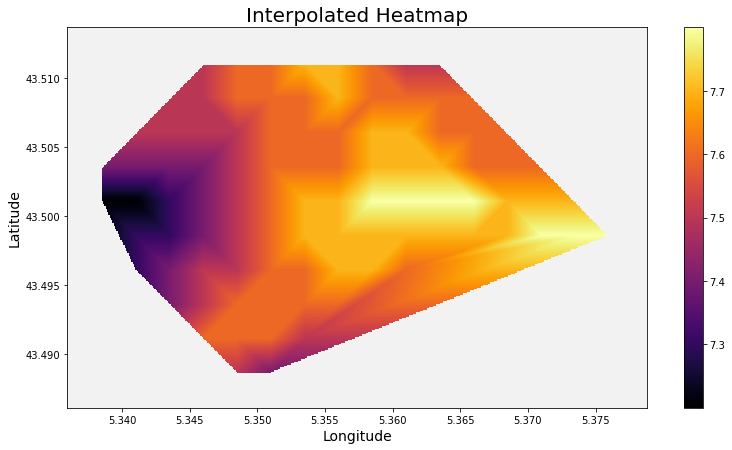

In [504]:
# Define the grid resolution
grid_res = 0.0001  # 10m resolution

# Define the grid boundaries
min_x, min_y, max_x, max_y = df.longitude.min(),df.latitude.min(), df.longitude.max(),df.latitude.max()


# Create a regular grid of points
x, y = np.meshgrid(np.arange(xmin, xmax, grid_res), np.arange(ymin, ymax, grid_res))
# Interpolate the data onto the regular grid
z = griddata((df.longitude, df.latitude), df.ph, (x, y), method='linear')

fig, ax = plt.subplots(figsize=(13, 7))
# Plot the heatmap
plt.imshow(z, origin='lower', extent=[xmin, xmax, ymin, ymax], cmap='inferno', aspect='auto')
plt.colorbar()

# set titles and labels
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Interpolated Heatmap',fontsize=20)

# Set the background color of the plot
ax.set_facecolor('#F2F2F2')

plt.show()